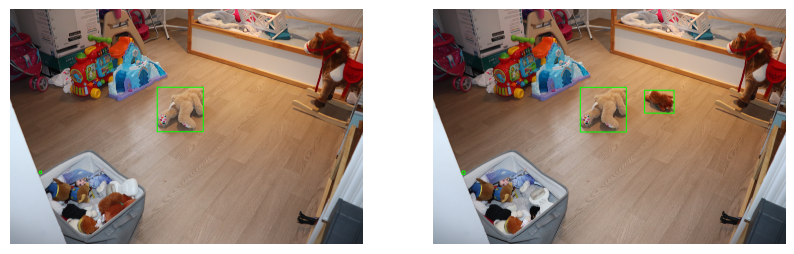

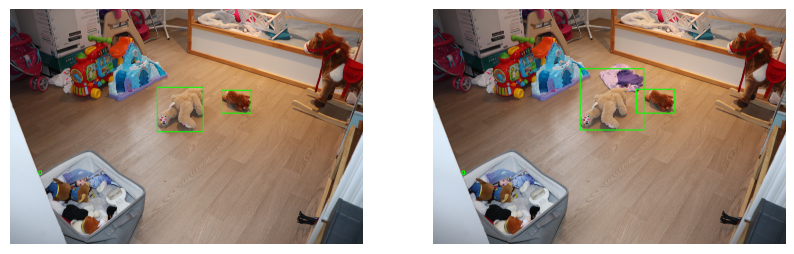

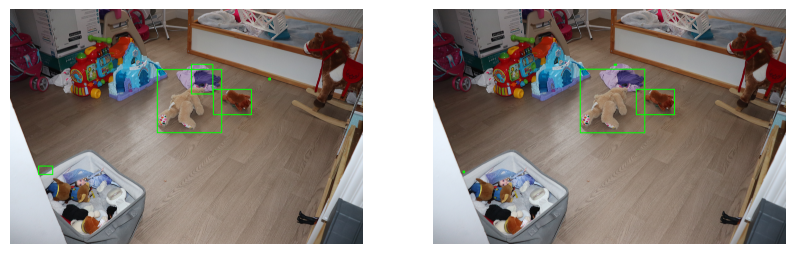

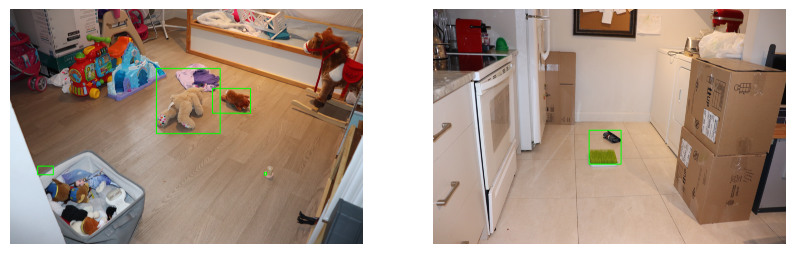

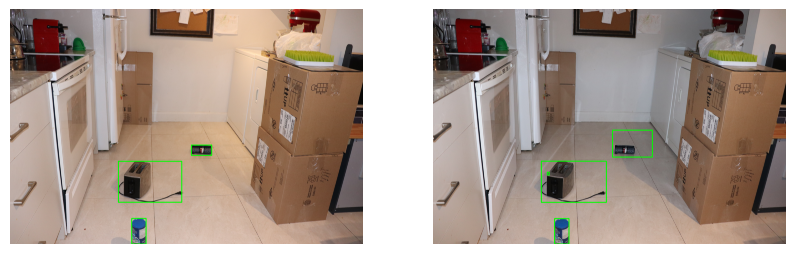

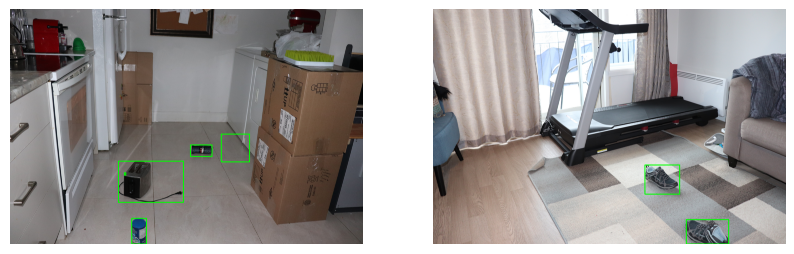

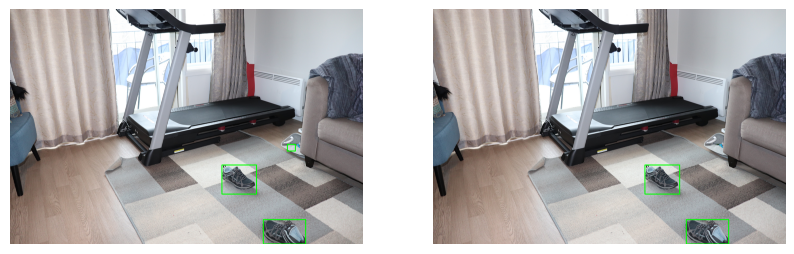

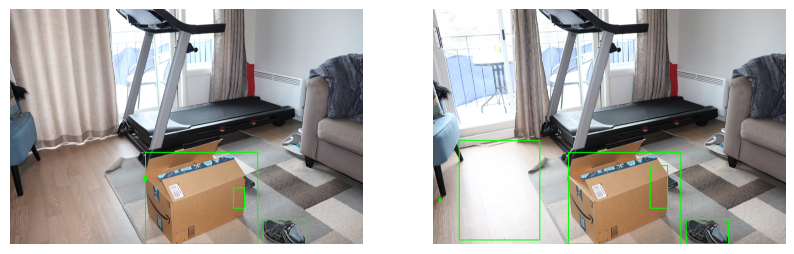

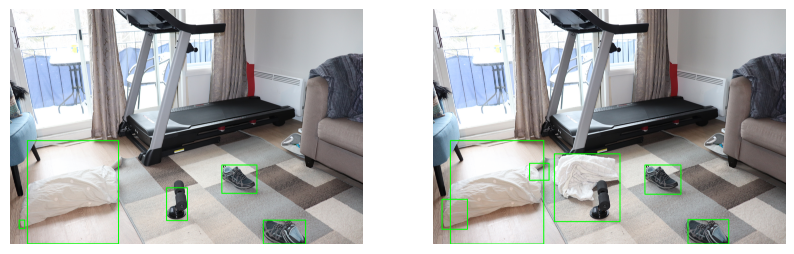

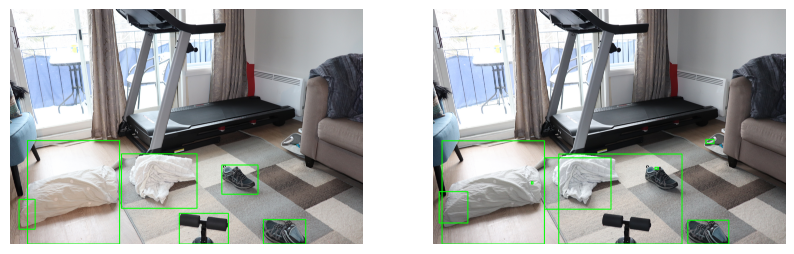

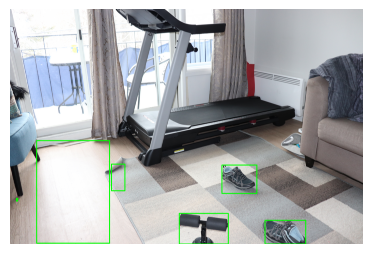

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#
# Dossier parent contenant les sous-dossiers
dossier_parent = 'Images'
# Liste des sous-dossiers à traiter
sous_dossiers = ['Chambre', 'Cuisine', 'Salon']
# Nom de l'image de référence dans chaque dossier
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Dossier parent contenant les sous-dossiers
dossier_parent = 'Images'
# Liste des sous-dossiers à traiter
sous_dossiers = ['Chambre', 'Cuisine', 'Salon']
# Nom de l'image de référence dans chaque dossier
nom_image_reference = 'Reference.JPG'

# Liste pour stocker les images traitées de tous les dossiers
images_traitees_globales = []

# Coordonnées des ROIs
roi_coords = {
    'Chambre': [
        {'roi': (100, 1500, 1000, 1200), 'angle': 150},
        {'roi': (2400, 2600, 2500, 2500), 'angle': 40},
        {'roi': (1500, 2100, 2000, 1000), 'angle': 40},
        {'roi': (700, 1500, 1200, 900), 'angle': 0},
        {'roi': (1900, 1500, 1500, 1000), 'angle': 60},
        {'roi': (2700, 1000, 2000, 1200), 'angle': 17},
        {'roi': (4200, 1800, 1400, 900), 'angle': 17},
        {'roi': (2300, 600, 800, 450), 'angle': 35}
    ],
    'Cuisine': [
        {'roi': (1900, 1900, 1800, 600), 'angle': 0},  # Premier ROI avec un angle de rotation de 20 degrés
        {'roi': (1700, 2300, 2380, 1800), 'angle': 0},  # Second ROI sans rotation
        {'roi': (1500, 2400, 200, 1800), 'angle': 0},  # Troisième ROI sans rotation
        {'roi': (1300, 2900, 200, 1200), 'angle': 0},
        {'roi': (1100, 3400, 200, 1200), 'angle': 0},
        {'roi': (4000, 3500, 2000, 500), 'angle': 0}
    ],
    'Salon': [
        {'roi': (2100, 2800, 3900, 1200), 'angle': 0},  # Premier ROI avec un angle de rotation de 20 degrés (3400, 1800, 1500, 800), 'angle': 165}
        {'roi': (30, 2500, 2200, 1900), 'angle': 160},  # Second ROI sans rotation
        {'roi': (2000, 2300, 3000, 900), 'angle': 165}
    ]
}

# Paramètres spécifiques à chaque pièce
folder_params = {
    'Chambre': {'clipLimit': 2.0, 'tileGridSize': (8, 8), 'contourThreshold': 80, 'aire_minimale': 600, 'SeuilDistance': 600},
    'Cuisine': {'clipLimit': 2.5, 'tileGridSize': (10, 10), 'contourThreshold': 80, 'aire_minimale': 700, 'SeuilDistance': 600},
    'Salon': {'clipLimit': 2.0, 'tileGridSize': (8, 8), 'contourThreshold': 80, 'aire_minimale': 800, 'SeuilDistance': 800},
}

def does_overlap(rect1, rect2):
    """
    Vérification si deux rectangles se chevauchent.
    """
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2

    # Vérifier si un rectangle est à gauche de l'autre
    if x1 > x2 + w2 or x2 > x1 + w1:
        return False

    # Vérifier si un rectangle est au-dessus de l'autre
    if y1 > y2 + h2 or y2 > y1 + h1:
        return False

    return True


def calculate_distance(rect1, rect2):
    """
    Calculer la distance entre les centres de deux rectangles.
    """
    center1_x, center1_y = rect1[0] + rect1[2] / 2, rect1[1] + rect1[3] / 2
    center2_x, center2_y = rect2[0] + rect2[2] / 2, rect2[1] + rect2[3] / 2

    # Distance euclidienne
    distance = ((center1_x - center2_x) ** 2 + (center1_y - center2_y) ** 2) ** 0.5
    return distance


def merge_rectangles(rectangles, distance_threshold):
    """
    Fusionne tous les rectangles qui se chevauchent ou sont plus proches que le seuil de distance.
    """
    if not rectangles:
        return []

    # Initialiser la liste des rectangles fusionnés
    merged = [rectangles[0]]
    
    for current in rectangles[1:]:
        merged_with_current = False
        for i, merged_rect in enumerate(merged):
            if does_overlap(current, merged_rect) or calculate_distance(current, merged_rect) < distance_threshold:
                # Fusionner les rectangles
                x1, y1, w1, h1 = current
                x2, y2, w2, h2 = merged_rect
                new_rect = (min(x1, x2), min(y1, y2), max(x1 + w1, x2 + w2) - min(x1, x2), max(y1 + h1, y2 + h2) - min(y1, y2))
                merged[i] = new_rect
                merged_with_current = True
                break
        
        if not merged_with_current:
            merged.append(current)
    
    return merged


# Fonctions pour la rotation et le dessin des rectangles
def rotate_point(origin, point, angle):
    """
    Rotation d'un point dans le sens anti-horaire autour d'un origine donnée.
    """
    ox, oy = origin
    px, py = point
    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy


def draw_rotated_rectangle(img, roi_dict):
    """
    Dessine un rectangle rotatif sur l'image.
    """
    cx, cy, width, height, angle = roi_dict['roi'] + (roi_dict['angle'],)
    angle = np.deg2rad(angle)
    center = (cx + width // 2, cy + height // 2)
    corners = [
        (cx, cy), (cx + width, cy),
        (cx + width, cy + height), (cx, cy + height)
    ]
    rotated_corners = [rotate_point(center, corner, angle) for corner in corners]
    pts = np.array(rotated_corners, np.int32).reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=15)


for sous_dossier in sous_dossiers:
    dossier_images = os.path.join(dossier_parent, sous_dossier)
    chemin_image_reference = os.path.join(dossier_images, nom_image_reference)
    image_reference = cv2.imread(chemin_image_reference)
    
    # Convertir l'image de référence en niveaux de gris
    gray_ref = cv2.cvtColor(image_reference, cv2.COLOR_BGR2GRAY)
    # Charger les paramètres spécifiques à la pièce
    params = folder_params[sous_dossier]
    
    # Créer l'objet CLAHE avec les paramètres spécifiques
    clahe = cv2.createCLAHE(clipLimit=params['clipLimit'], tileGridSize=params['tileGridSize'])

    clahe_ref = clahe.apply(gray_ref)
    # Application du lissage Gaussien
    gauss_ref = cv2.GaussianBlur(clahe_ref, (5, 5), 0)

    # Obtenir une liste de tous les fichiers dans le dossier
    fichiers = os.listdir(dossier_images)

    # Filtrer pour ne garder que les fichiers d'images (par exemple, .JPG) et exclure l'image de référence
    images_test = [f for f in fichiers if f.endswith('.JPG') and f != nom_image_reference]
    roi_info = roi_coords.get(sous_dossier, [])
    
    for nom_image_test in images_test:
        rectangles = []
        chemin_image_test = os.path.join(dossier_images, nom_image_test)
        # Charger les images
        image_test = cv2.imread(chemin_image_test)
        # Convertir en niveaux de gris
        gray_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
        # Appliquer CLAHE
        clahe_test = clahe.apply(gray_test)
        # Appliquer le lissage Gaussien
        gauss_test = cv2.GaussianBlur(clahe_test, (5, 5), 0)
        
        # Soustraction d'images et seuillage
        diff = cv2.absdiff(gauss_ref, gauss_test)
        _, thresh = cv2.threshold(diff,folder_params[sous_dossier]['contourThreshold'], 255, cv2.THRESH_BINARY)
        # Trouver des contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Approximation des contours
        contours_approx = [cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), 
                                            True) for contour in contours]

        # Initialiser une image masque pour dessiner les ROIs
        mask = np.zeros_like(image_test)
        
        # Dessiner les contours approximés sur l'image
        image_contours = image_test.copy()
        #cv2.drawContours(image_contours, contours_approx, -1, (0, 255, 0), 3)

        # Seuil d'aire pour les rectangles
        # Récupérer la valeur de l'aire minimale du dossier spécifique
        aire_minimale = folder_params[sous_dossier].get('aire_minimale', 700)  
        
        # Dessiner les ROIs sur l'image
        for roi_dict in roi_info:
            if roi_dict['angle'] == 0:
                # Pour un rectangle sans rotation
                x, y, width, height = roi_dict['roi']
                #cv2.rectangle(image_test, (x, y), (x + width, y + height), (0, 0, 255), 15)
            #else:
                # Pour un rectangle avec rotation
                #draw_rotated_rectangle(image_test, roi_dict)

        # Vérifier si chaque contour est dans au moins un ROI avant de le dessiner
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            contour_center = (x + w // 2, y + h // 2)
            
            contour_dans_roi = False
            for roi_dict in roi_info:
                # Vérification pour les rectangles sans rotation
                if roi_dict['angle'] == 0:
                    roi_x, roi_y, roi_width, roi_height = roi_dict['roi']
                    if roi_x <= contour_center[0] <= roi_x + roi_width and roi_y <= contour_center[1] <= roi_y + roi_height:
                        contour_dans_roi = True
                        break
                else:
                    # Vérification pour les rectangles avec rotation
                    angle_rad = np.deg2rad(-roi_dict['angle'])
                    cx, cy, width, height = roi_dict['roi']
                    center_roi = (cx + width // 2, cy + height // 2)
                    rotated_point = rotate_point(center_roi, contour_center, angle_rad)
                    if cx <= rotated_point[0] <= cx + width and cy <= rotated_point[1] <= cy + height:
                        contour_dans_roi = True

            # Dessiner le rectangle englobant en vert seulement si le contour est à l'intérieur d'un ROI
            if contour_dans_roi:
                aire = w * h
                if aire > aire_minimale:  # Dessiner seulement si l'aire dépasse le seuil
                    #cv2.rectangle(image_test, (x, y), (x+w, y+h), (0, 255, 0), 15)
                    # Rectangle dessiné
                    rectangles.append((x, y, w, h))
            
        # Fusionner les rectangles qui se chevauchent ou sont proches
        merged_rectangles = merge_rectangles(rectangles, folder_params[sous_dossier]['SeuilDistance'])

        # Dessiner les rectangles fusionnés sur l'image
        for (x, y, w, h) in merged_rectangles:
            cv2.rectangle(image_test, (x, y), (x + w, y + h), (0, 255, 0), 15)  # Utiliser une couleur distincte pour le visuel


        # Convertir l'image BGR en RGB pour l'affichage avec Matplotlib
        image_test_rgb = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
        images_traitees_globales.append(image_test_rgb)  # Assurez-vous que cette image est dans le format correct pour l'affichage (RGB si nécessaire)


# Afficher les images traitées 2 par 2
n = 2
for i in range(0, len(images_traitees_globales), n):
    plt.figure(figsize=(10, 5))
    for j in range(n):
        if i + j < len(images_traitees_globales):
            plt.subplot(1, n, j + 1)
            plt.imshow(images_traitees_globales[i + j])
            plt.axis('off')
    plt.show()
